This archive contains 2075259 measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months).

1.date: Date in format dd/mm/yyyy
2.time: time in format hh:mm:ss
3.global_active_power: household global hour-averaged active power (in kilowatt)
4.global_reactive_power: household global hour-averaged reactive power (in kilowatt)
5.voltage: hour-averaged voltage (in volt)
6.global_intensity: household global hour-averaged current intensity (in ampere)
7.sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).
8.sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.
9.sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner

In [1]:
pip install pandas matplotlib seaborn plotly

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

# Charger les données
df = pd.read_csv("main_data.csv", parse_dates=["DateTime"])

# Vérifier les premières lignes
print(df.head())


             DateTime  Global_active_power  Global_reactive_power     Voltage  \
0 2006-12-16 17:00:00             4.222889               0.229000  234.643889   
1 2006-12-16 18:00:00             3.632200               0.080033  234.580167   
2 2006-12-16 19:00:00             3.400233               0.085233  233.232500   
3 2006-12-16 20:00:00             3.268567               0.075100  234.071500   
4 2006-12-16 21:00:00             3.056467               0.076667  237.158667   

   Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  YEAR  MO  \
0         18.100000             0.0        0.527778       16.861111  2006  12   
1         15.600000             0.0        6.716667       16.866667  2006  12   
2         14.503333             0.0        1.433333       16.683333  2006  12   
3         13.916667             0.0        0.000000       16.783333  2006  12   
4         13.046667             0.0        0.416667       17.216667  2006  12   

   DY  HR   T2M  QV2M  WS1

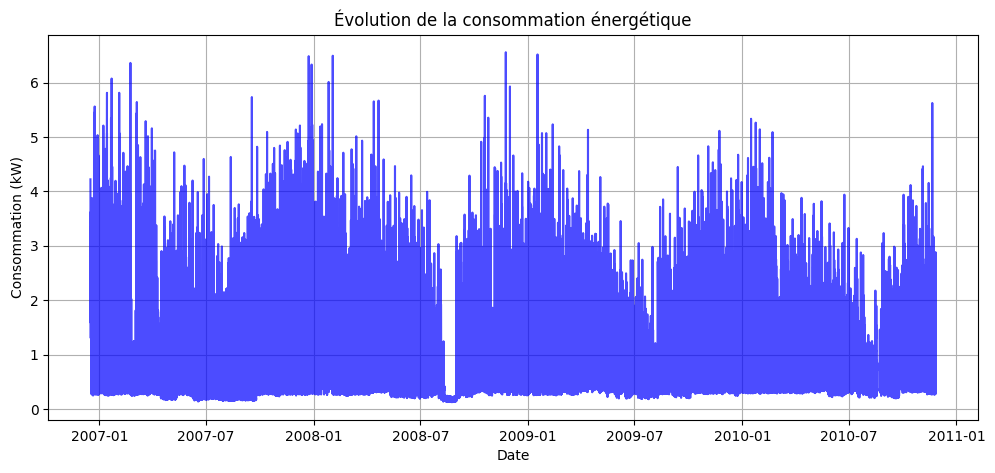

In [3]:
plt.figure(figsize=(12, 5))
plt.plot(df["DateTime"], df["Global_active_power"], color="blue", alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Consommation (kW)")
plt.title("Évolution de la consommation énergétique")
plt.grid(True)
plt.show()

On remarque que la consommation électrique est périodique de période 1 ans

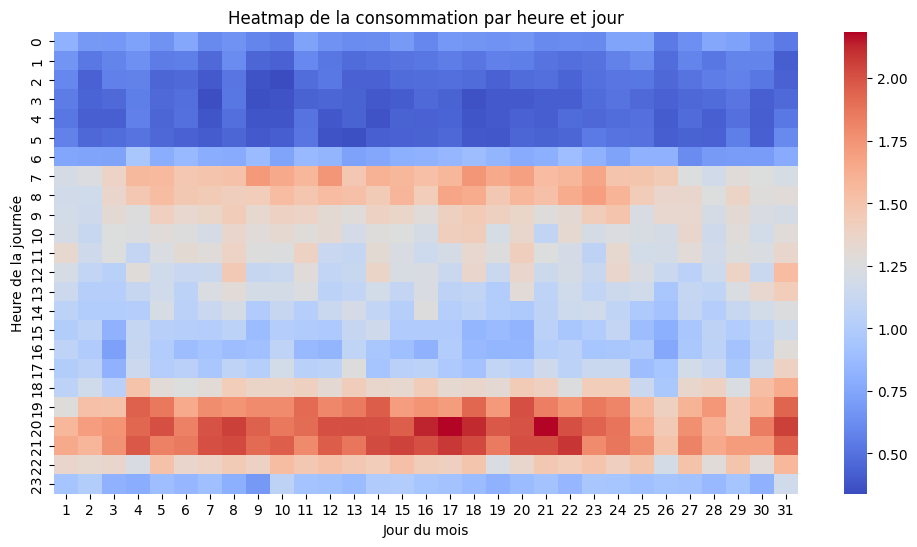

In [4]:
# Extraire heure et jour
df["Hour"] = df["DateTime"].dt.hour
df["Day"] = df["DateTime"].dt.day

# Moyenne de consommation par heure et jour
heatmap_data = df.pivot_table(values="Global_active_power", index="Hour", columns="Day", aggfunc="mean")

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="coolwarm", annot=False)
plt.title("Heatmap de la consommation par heure et jour")
plt.xlabel("Jour du mois")
plt.ylabel("Heure de la journée")
plt.show()

On remarque que lors d'une journée il y a une forte consommation énergétique entre 18h et 22h alors que la consommation est faible entre 23h et 6h ce qui peut nous pousser à installer des panneau solaire qui produisent de l'electricité pendant la journée mais qui a pour défault principile de ne rien produire la nuit. Au cours de la journée il y a une baisse de la consommation entre 13h et 18h on peut donc penser à baisser la production électrique durant cette periode.

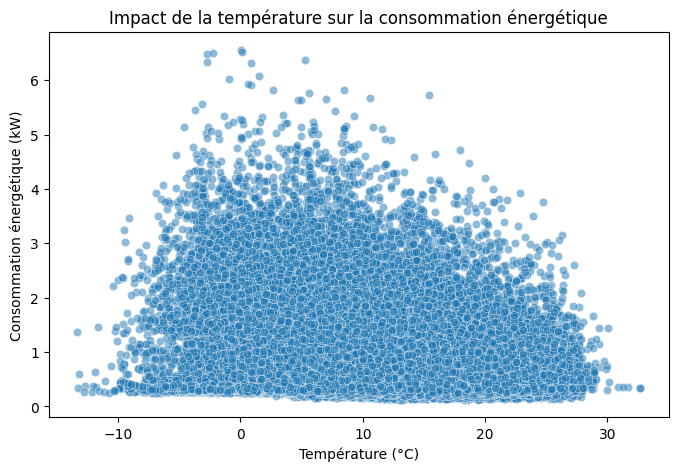

In [5]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df["T2M"], y=df["Global_active_power"], alpha=0.5)
plt.xlabel("Température (°C)")
plt.ylabel("Consommation énergétique (kW)")
plt.title("Impact de la température sur la consommation énergétique")
plt.show()


On observe une tendance où une température plus élevée est associée à une consommation énergétique plus faible. Toutefois, certaines valeurs restent étonnamment basses lorsque la température atteint -10°C. Ces points semblent être des outliers, d'autant plus que des températures aussi basses sont rares à Paris, ce qui renforce l'hypothèse de valeurs aberrantes.

<ipython-input-6-6e57a306dcd3>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["DayOfWeek"], y=df["Global_active_power"], palette="Set2")


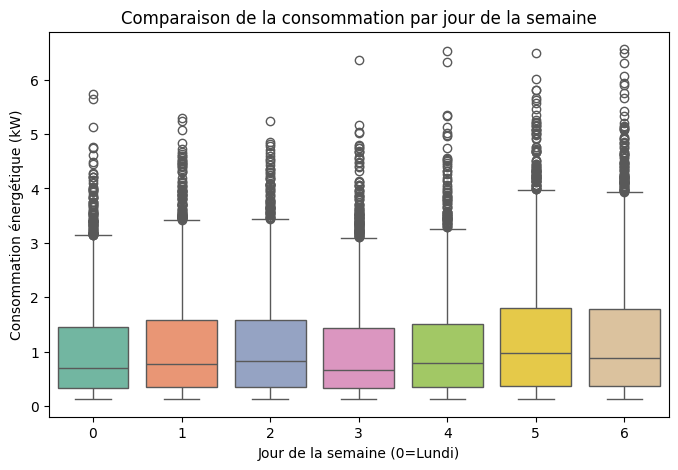

In [6]:
df["DayOfWeek"] = df["DateTime"].dt.dayofweek  # 0 = Lundi, 6 = Dimanche

plt.figure(figsize=(8, 5))
sns.boxplot(x=df["DayOfWeek"], y=df["Global_active_power"], palette="Set2")
plt.xlabel("Jour de la semaine (0=Lundi)")
plt.ylabel("Consommation énergétique (kW)")
plt.title("Comparaison de la consommation par jour de la semaine")
plt.show()


On constate que la consommation moyenne est plus élevée le dimanche, et particulièrement le mercredi et le samedi, ce qui correspond aux jours de repos. Les consommations extrêmes se produisent principalement le samedi et le dimanche, probablement parce que les gens passent plus de temps chez eux. Cependant, il est intéressant de noter que la consommation du dimanche est inférieure à celle du mercredi et du samedi, ce qui peut sembler contre-intuitif

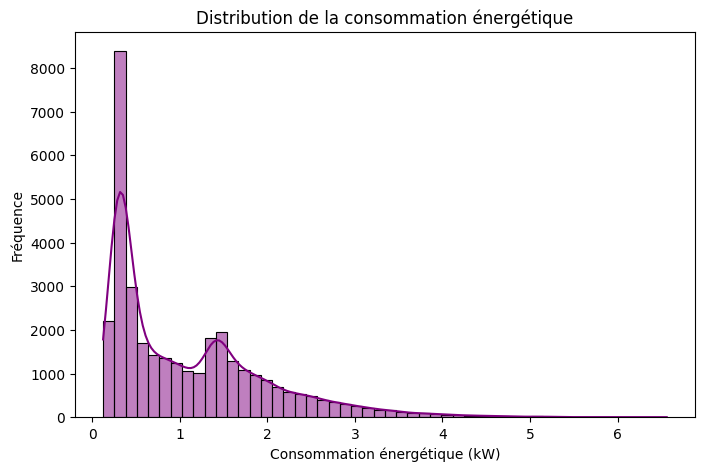

In [7]:
plt.figure(figsize=(8, 5))
sns.histplot(df["Global_active_power"], bins=50, kde=True, color="purple")
plt.xlabel("Consommation énergétique (kW)")
plt.ylabel("Fréquence")
plt.title("Distribution de la consommation énergétique")
plt.show()


On remarque qu'il y a une demande fréquente de consommation énergétique faible ce qui peux correspondre à des appareil en veille durant les heures creuses. On remarque aussi qu'il y a 2 pics 1 à 0.5 kw et l'autre à 1,5kw ce qui peut correspondre a la période entre 23h et 6h pour le pic à 0,5 et la période entre 18h et 22h pour le pic à beaucoup plus faible à 1,5

In [8]:
fig = px.line(df, x="DateTime", y="Global_active_power", title="Consommation énergétique interactive")
fig.show()

DEBUG:cmdstanpy:input tempfile: /tmp/tmpvpxu2wid/gjl9qsiw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvpxu2wid/a9ahj_l8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22887', 'data', 'file=/tmp/tmpvpxu2wid/gjl9qsiw.json', 'init=/tmp/tmpvpxu2wid/a9ahj_l8.json', 'output', 'file=/tmp/tmpvpxu2wid/prophet_modelsne6xyh0/prophet_model-20250320141801.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:18:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:18:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



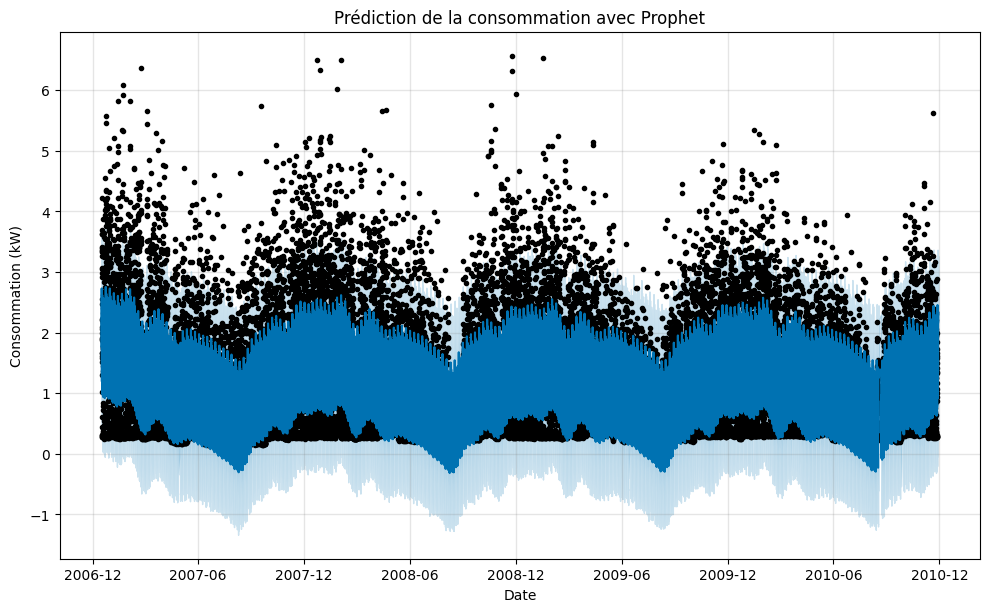

In [9]:
# Préparer les données pour Prophet
df_prophet = df.reset_index()[["DateTime", "Global_active_power"]].rename(columns={"DateTime": "ds", "Global_active_power": "y"})

# Définition du modèle
prophet_model = Prophet()
prophet_model.fit(df_prophet)

# Création du futur (48h)
future = prophet_model.make_future_dataframe(periods=48, freq="H")
forecast = prophet_model.predict(future)

# Visualisation
fig = prophet_model.plot(forecast)
plt.title("Prédiction de la consommation avec Prophet")
plt.xlabel("Date")
plt.ylabel("Consommation (kW)")
plt.show()

Nous tentons de prédire la consommation énergétique à l’aide de la courbe bleu foncé, tandis que la courbe bleu clair représente l’incertitude associée aux prévisions, et les points noirs correspondent aux valeurs réelles observées. On constate que le modèle parvient à bien capturer la saisonnalité des données, mais qu’il génère certaines prédictions aberrantes, notamment des valeurs négatives, ce qui est incohérent d’un point de vue physique, car une consommation énergétique ne peut pas être inférieure à zéro